In [10]:
# --- KOMÓRKA 1: BIBLIOTEKI ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Ustawienia estetyczne wykresów
plt.style.use('seaborn-v0_8-darkgrid')
print("Biblioteki załadowane pomyślnie.")

Biblioteki załadowane pomyślnie.


In [11]:
# --- KOMÓRKA 2: WCZYTANIE DANYCH ---
# Sprawdzamy, czy mamy ścieżkę z poprzednich komórek, jeśli nie - używamy domyślnej
if 'OUTPUT_FILE' in locals():
    print(f"Wczytuję dane z: {OUTPUT_FILE}")
    df = pd.read_csv(OUTPUT_FILE)
else:
    path = '/content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv'
    print(f"Używam ścieżki awaryjnej: {path}")
    try:
        df = pd.read_csv(path)
        print("Dane wczytane poprawnie.")
    except FileNotFoundError:
        print("BŁĄD: Nie znaleziono pliku. Uruchom najpierw komórkę konfiguracyjną (tę pierwszą w całym notesie)!")
        df = pd.DataFrame()

Wczytuję dane z: /content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv


In [12]:
# --- KOMÓRKA 3: INŻYNIERIA CECH ---
if not df.empty:
    print("Tworzę cechy fizyczne: Interakcja, Straty Cieplne, Lag...")

    # 1. INTERAKCJA (Moc = Moment * Prędkość) - BAZA
    df['inter_fr'] = df['setpoint_fr'] * df['speed_fr']
    df['inter_rl'] = df['setpoint_rl'] * df['speed_rl']
    df['inter_rr'] = df['setpoint_rr'] * df['speed_rr']

    # 2. STRATY CIEPLNE (Setpoint^2) - DODATEK 1
    df['heat_fr'] = df['setpoint_fr'] ** 2
    df['heat_rl'] = df['setpoint_rl'] ** 2
    df['heat_rr'] = df['setpoint_rr'] ** 2

    # 3. LAG (Opóźnienie) - DODATEK 2
    # Suma setpointów przesunięta o 1 krok w tył
    df['total_setpoint'] = df['setpoint_fr'] + df['setpoint_rl'] + df['setpoint_rr']
    df['lag_setpoint'] = df['total_setpoint'].shift(1).fillna(0)

    # 4. PODSTAWA DYNAMIKI (Niezbędne dla szeregów czasowych)
    # Przyspieszenie
    df['acc_fr'] = df['speed_fr'].diff().fillna(0)
    df['acc_rl'] = df['speed_rl'].diff().fillna(0)
    df['acc_rr'] = df['speed_rr'].diff().fillna(0)

    # Wygładzanie (Rolling mean)
    df['roll_speed_fr'] = df['speed_fr'].rolling(window=5, min_periods=1).mean()
    df['roll_speed_rl'] = df['speed_rl'].rolling(window=5, min_periods=1).mean()
    df['roll_speed_rr'] = df['speed_rr'].rolling(window=5, min_periods=1).mean()

    # Usuwamy puste wiersze (powstałe przez shift/diff)
    df.dropna(inplace=True)
    print("Cechy dodane. Gotowe do podziału danych.")
else:
    print("Brak danych do przetworzenia.")

Tworzę cechy fizyczne: Interakcja, Straty Cieplne, Lag...
Cechy dodane. Gotowe do podziału danych.


In [13]:
# --- KOMÓRKA 4: PODZIAŁ DANYCH ---
if not df.empty:
    X = df.drop(columns=['power'])
    y = df['power']

    # Podział: 80% nauka, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Dane gotowe.")
    print(f"Zbiór treningowy: {X_train.shape[0]} próbek")
    print(f"Zbiór testowy:    {X_test.shape[0]} próbek")

Dane gotowe.
Zbiór treningowy: 41441 próbek
Zbiór testowy:    10361 próbek


In [14]:
# --- KOMÓRKA 5: TRENING ---
# Definicja modelu
model = GradientBoostingRegressor(
    n_estimators=300,        # Liczba drzew
    learning_rate=0.1,       # Szybkość uczenia
    max_depth=5,             # Głębokość drzewa
    random_state=42,
    validation_fraction=0.1, # 10% treningu używamy do walidacji w locie
    n_iter_no_change=10      # Zatrzymaj jeśli nie ma poprawy
)

print(f"Rozpoczynam trening modelu Gradient Boosting...")
model.fit(X_train, y_train)
print("Trening zakończony sukcesem!")

Rozpoczynam trening modelu Gradient Boosting...
Trening zakończony sukcesem!



 PEŁNY RAPORT WYNIKÓW MODELU
R2 Score (Dopasowanie):       0.9862 (max 1.0)
RMSE (Błąd pierwiastkowy):    180588.81 W
MAE (Średni błąd):            86469.58 W
MedAE (Mediana błędu):        36600.23 W  <-- Typowa pomyłka
--------------------------------------------------
MAPE (Średni błąd %):         23430172726712225792.00%
Średni błąd % (z próbek):     5202543462.59%


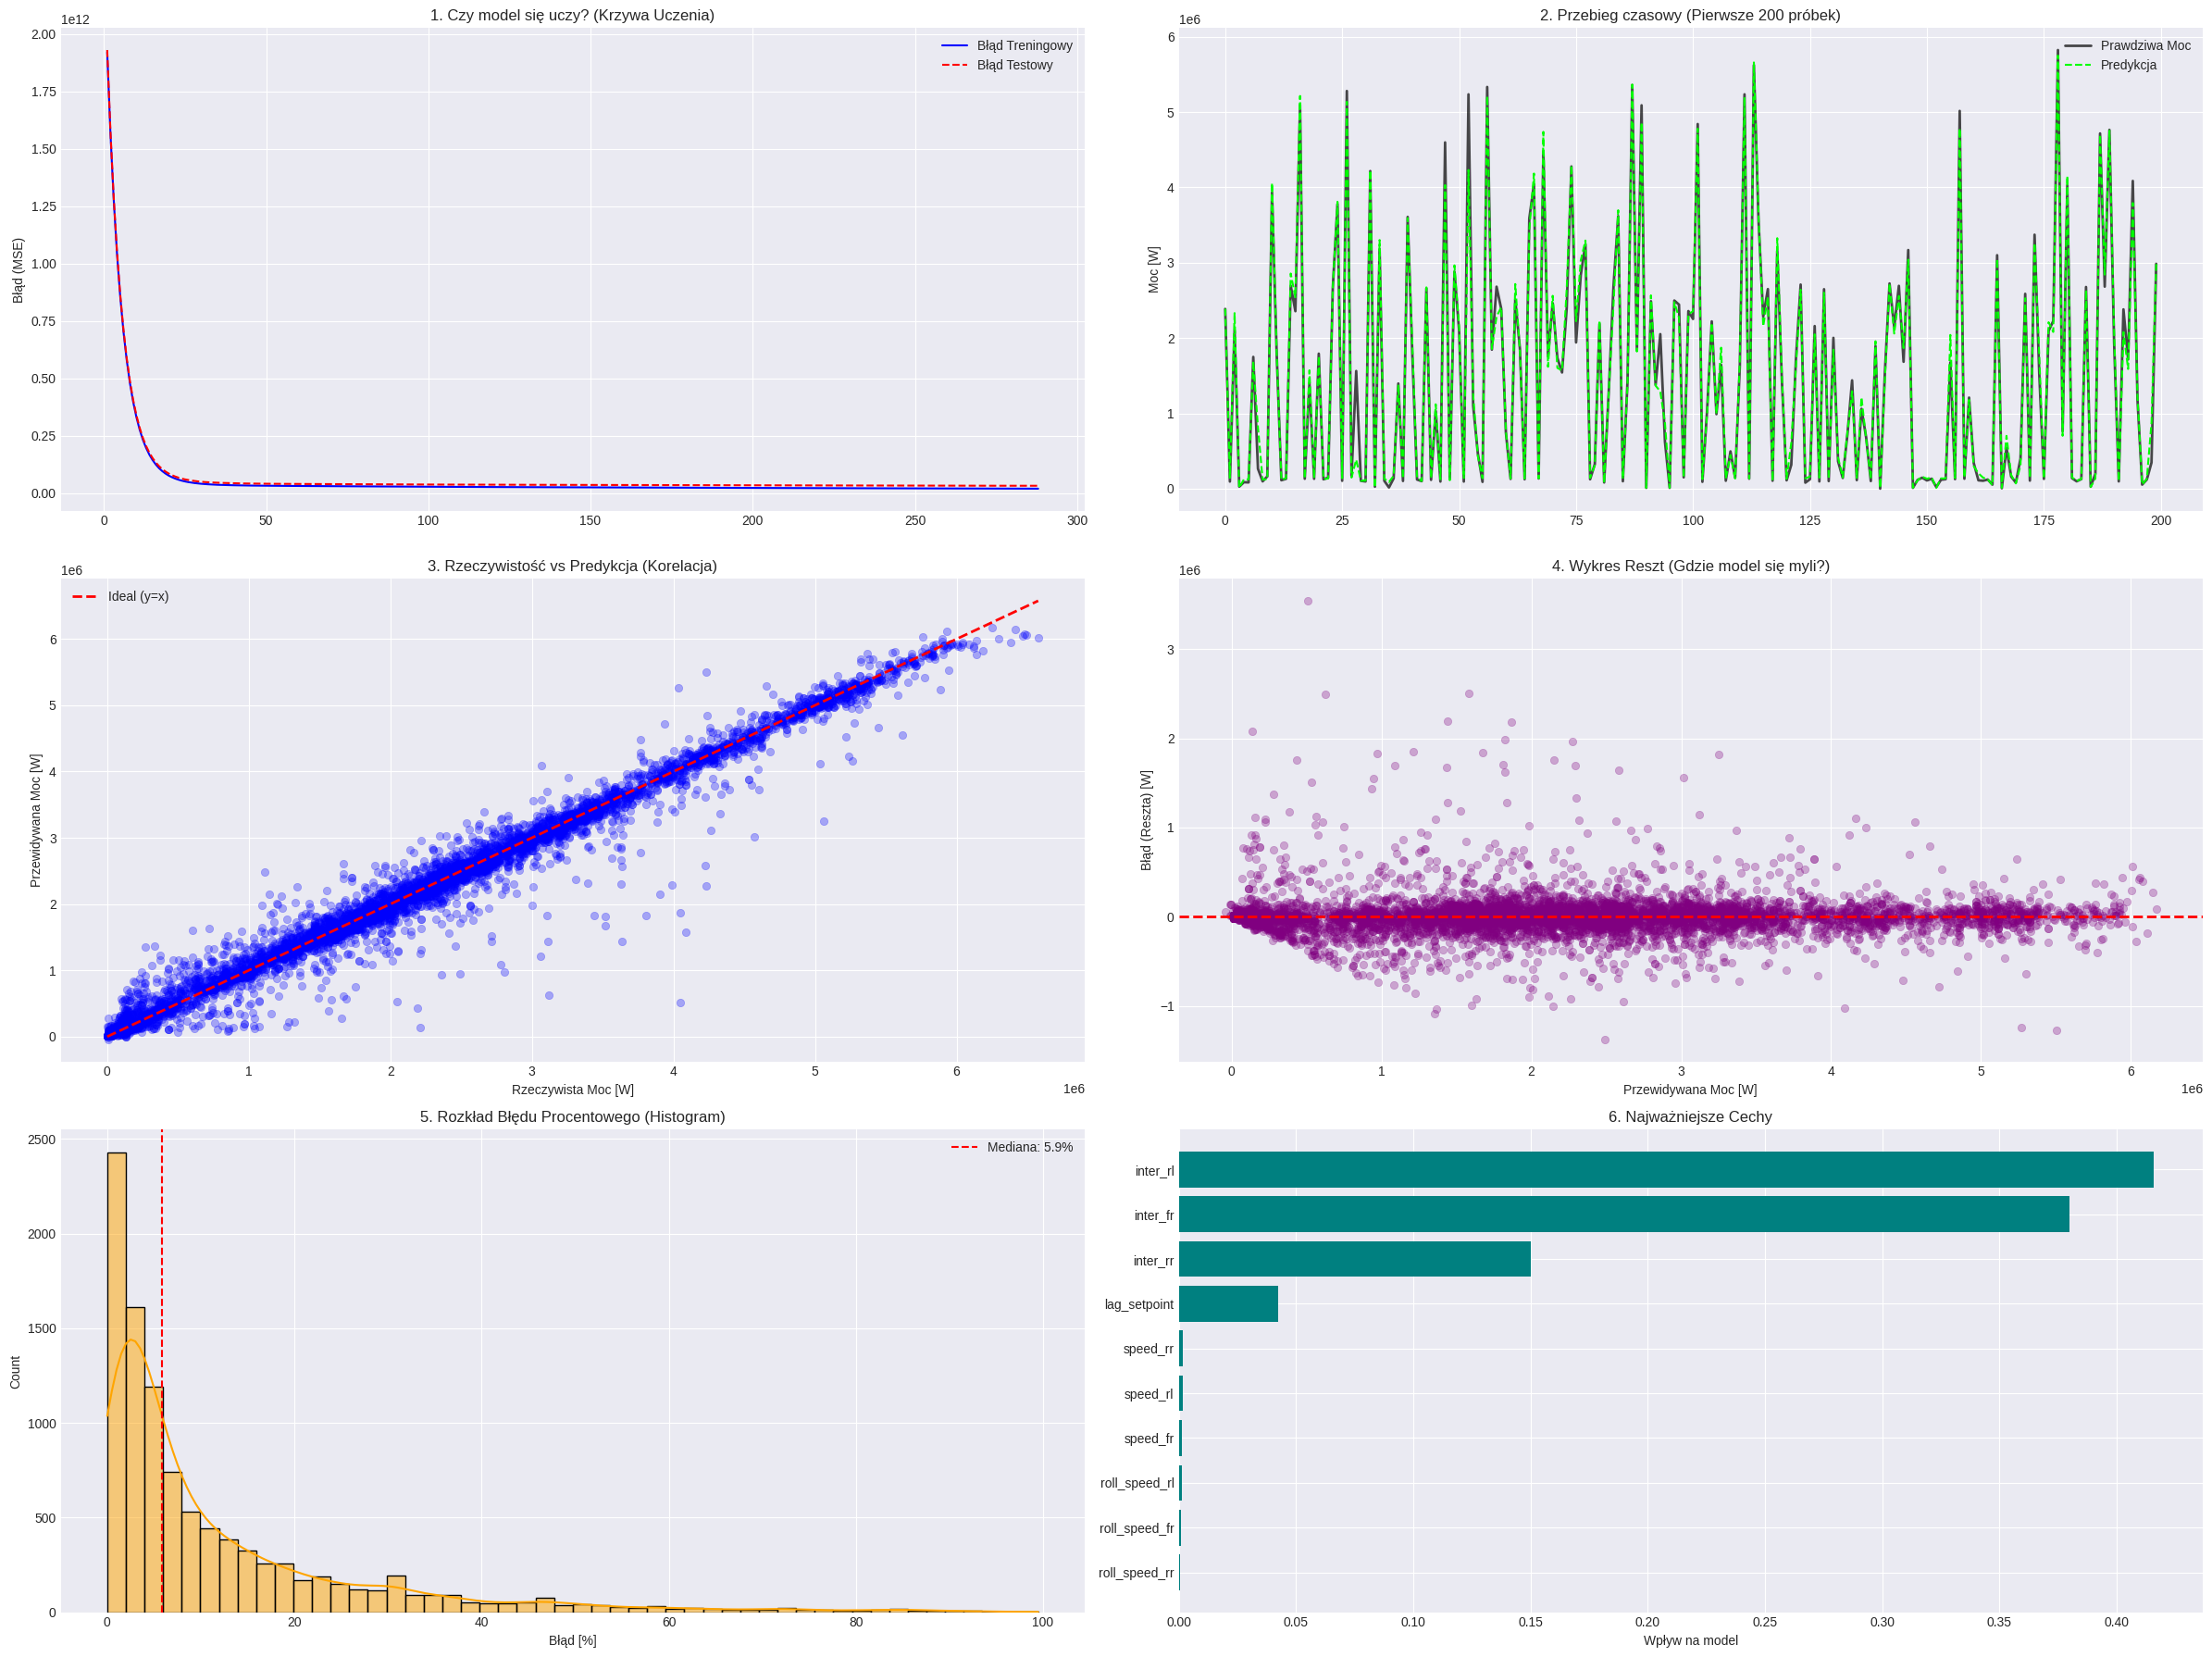

In [21]:
# --- KOMÓRKA 6: KOMPLETNA ANALIZA (STARE + NOWE WYKRESY) ---
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import seaborn as sns
import numpy as np

# 1. Obliczenia predykcji
y_pred = model.predict(X_test)

# 2. Obliczenia szczegółowych błędów
residuals = y_test - y_pred          # Reszty (różnica w Watach)
abs_errors = np.abs(residuals)       # Błąd bezwzględny

# Błąd procentowy dla każdej próbki (dodajemy mały epsilon 1e-6 żeby nie dzielić przez 0)
pct_errors_per_sample = (abs_errors / (np.abs(y_test) + 1e-6)) * 100

# 3. Metryki zbiorcze
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
medae = median_absolute_error(y_test, y_pred)

print("\n" + "="*50)
print(f" PEŁNY RAPORT WYNIKÓW MODELU")
print("="*50)
print(f"R2 Score (Dopasowanie):       {r2:.4f} (max 1.0)")
print(f"RMSE (Błąd pierwiastkowy):    {rmse:.2f} W")
print(f"MAE (Średni błąd):            {mae:.2f} W")
print(f"MedAE (Mediana błędu):        {medae:.2f} W  <-- Typowa pomyłka")
print("-" * 50)
print(f"MAPE (Średni błąd %):         {mape:.2f}%")
print(f"Średni błąd % (z próbek):     {np.mean(pct_errors_per_sample):.2f}%")
print("="*50)

# --- WIZUALIZACJA (Siatka 3 wiersze x 2 kolumny) ---
fig, axes = plt.subplots(3, 2, figsize=(24, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# WYKRES 1 (STARY): Krzywa Uczenia
# Musimy obliczyć błędy dla każdego etapu (drzewa)
train_score = model.train_score_
test_score = np.zeros((len(train_score),), dtype=np.float64)
for i, y_pred_staged in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred_staged)

axes[0, 0].plot(np.arange(len(train_score)) + 1, train_score, 'b-', label='Błąd Treningowy')
axes[0, 0].plot(np.arange(len(train_score)) + 1, test_score, 'r--', label='Błąd Testowy')
axes[0, 0].set_title('1. Czy model się uczy? (Krzywa Uczenia)')
axes[0, 0].set_ylabel('Błąd (MSE)')
axes[0, 0].legend()

# WYKRES 2 (STARY): Rzeczywistość vs Model (Zoom Czasowy)
subset = 200
axes[0, 1].plot(y_test.values[:subset], label='Prawdziwa Moc', color='black', alpha=0.7, linewidth=2)
axes[0, 1].plot(y_pred[:subset], label='Predykcja', color='lime', linestyle='--')
axes[0, 1].set_title(f'2. Przebieg czasowy (Pierwsze {subset} próbek)')
axes[0, 1].set_ylabel('Moc [W]')
axes[0, 1].legend()

# WYKRES 3 (NOWY): Scatter Plot (Idealne dopasowanie)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, ax=axes[1, 0], color='blue', edgecolor=None)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal (y=x)')
axes[1, 0].set_title('3. Rzeczywistość vs Predykcja (Korelacja)')
axes[1, 0].set_xlabel('Rzeczywista Moc [W]')
axes[1, 0].set_ylabel('Przewidywana Moc [W]')
axes[1, 0].legend()

# WYKRES 4 (NOWY): Analiza Reszt (Błąd vs Predykcja)
# Pozwala wykryć czy model myli się bardziej przy dużej mocy
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, ax=axes[1, 1], color='purple', edgecolor=None)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_title('4. Wykres Reszt (Gdzie model się myli?)')
axes[1, 1].set_xlabel('Przewidywana Moc [W]')
axes[1, 1].set_ylabel('Błąd (Reszta) [W]')

# WYKRES 5 (NOWY): Histogram Błędów Procentowych
# Obcinamy outliery powyżej 100% błędu dla czytelności wykresu
filtered_pct = pct_errors_per_sample[pct_errors_per_sample < 100]
sns.histplot(filtered_pct, bins=50, ax=axes[2, 0], color='orange', kde=True)
axes[2, 0].axvline(np.median(pct_errors_per_sample), color='red', linestyle='--', label=f'Mediana: {np.median(pct_errors_per_sample):.1f}%')
axes[2, 0].set_title('5. Rozkład Błędu Procentowego (Histogram)')
axes[2, 0].set_xlabel('Błąd [%]')
axes[2, 0].legend()

# WYKRES 6 (STARY): Ważność Cech
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
axes[2, 1].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='teal')
axes[2, 1].set_yticks(range(len(sorted_idx)))
axes[2, 1].set_yticklabels(np.array(X.columns)[sorted_idx])
axes[2, 1].set_title('6. Najważniejsze Cechy')
axes[2, 1].set_xlabel('Wpływ na model')

plt.tight_layout()
plt.show()